In [43]:
from matplotlib import pyplot as plt
from src.ml.data.data_loader import load_raw_data
from sklearn.cluster import KMeans

processed_data_path = '/Users/aya/Desktop/ML/insurance-recommender/data/processed/processed_user_data.csv'
processed_user_data = load_raw_data(processed_data_path)
processed_user_data

,_id,PCA1,PCA2,PCA3
0,65a713cc1dfebcf6ca173f0d,-2.037575,0.332517,-0.666090
1,65a714291dfebcf6ca173f0e,-1.993900,-0.033364,1.472070
2,65a714641dfebcf6ca173f0f,-1.695471,-0.979096,-0.486467
3,65a71f2e1dfebcf6ca173f12,-0.057793,-1.179193,2.304860
4,65a723fd1dfebcf6ca173f15,-1.255405,0.279032,0.216232
...,...,...,...,...
78,65abf36abb5fc22fe3d2718f,-2.546522,0.605423,-0.244263
79,65abf36ebb5fc22fe3d27190,-2.559252,0.602865,-0.215834
80,65abf39ebb5fc22fe3d27191,-2.461803,0.730673,-0.344237
81,65abf3d8bb5fc22fe3d27192,-2.024844,0.335075,-0.694519


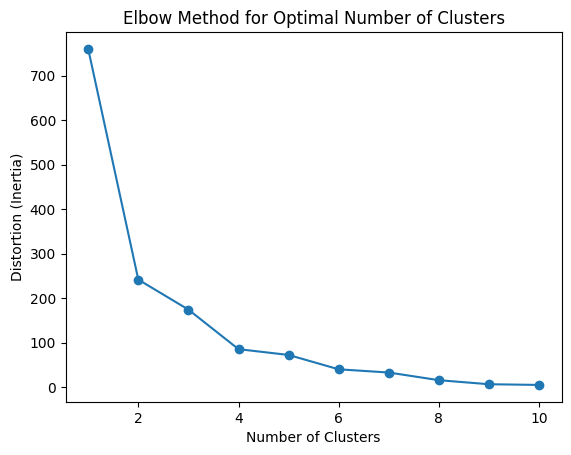

In [44]:
features_for_clustering = processed_user_data[['PCA1', 'PCA2', 'PCA3']]

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(features_for_clustering)
    wcss.append(kmeans.inertia_)
    
# Plotting the Elbow Method graph
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion (Inertia)')
plt.show()

                         _id      PCA1      PCA2      PCA3  cluster
0   65a713cc1dfebcf6ca173f0d -2.037575  0.332517 -0.666090        9
1   65a714291dfebcf6ca173f0e -1.993900 -0.033364  1.472070        7
2   65a714641dfebcf6ca173f0f -1.695471 -0.979096 -0.486467        6
3   65a71f2e1dfebcf6ca173f12 -0.057793 -1.179193  2.304860        3
4   65a723fd1dfebcf6ca173f15 -1.255405  0.279032  0.216232        0
..                       ...       ...       ...       ...      ...
78  65abf36abb5fc22fe3d2718f -2.546522  0.605423 -0.244263        4
79  65abf36ebb5fc22fe3d27190 -2.559252  0.602865 -0.215834        4
80  65abf39ebb5fc22fe3d27191 -2.461803  0.730673 -0.344237        4
81  65abf3d8bb5fc22fe3d27192 -2.024844  0.335075 -0.694519        9
82  65abf408bb5fc22fe3d27193 -2.024844  0.335075 -0.694519        9

[83 rows x 5 columns]


['/Users/aya/Desktop/ML/insurance-recommender/src/ml/models/kmeans_model.joblib']

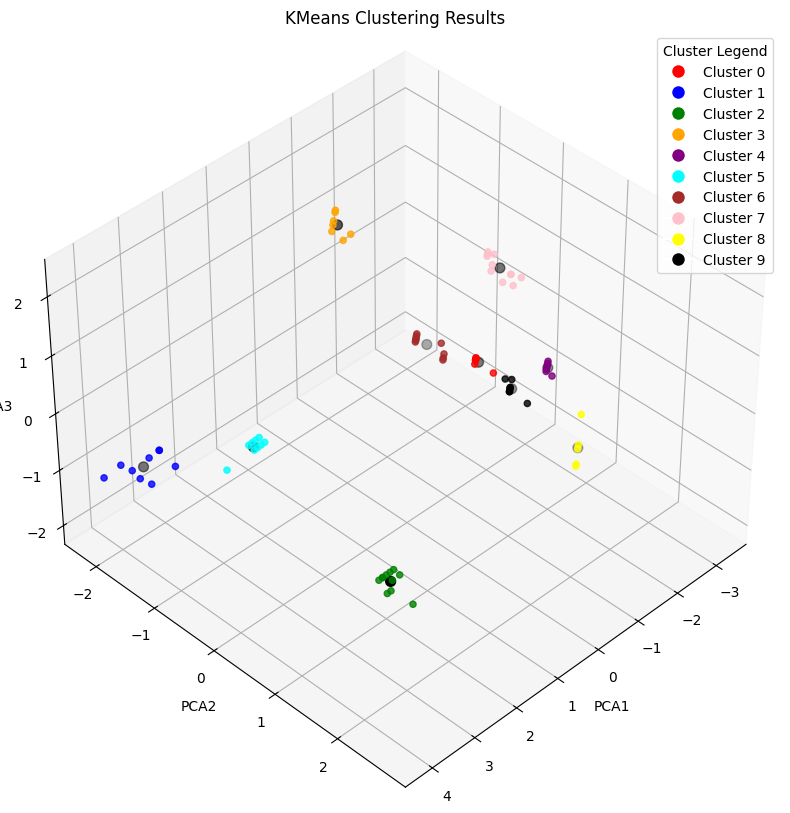

In [50]:
import joblib
import pandas as pd
# Based on the Elbow Method, choose the optimal number of clusters
optimal_clusters = 10  # Choose the point where the distortion starts to decrease more slowly (the "elbow")

# Clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters)
processed_user_data['cluster'] = kmeans.fit_predict(features_for_clustering)
processed_user_data.to_csv('/Users/aya/Desktop/ML/insurance-recommender/data/processed/users_clusters.csv', index=False)

centroids = kmeans.cluster_centers_
print(processed_user_data)

# Visualize the clustering results with a 3D scatter plot
cluster_colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'brown', 'pink','yellow','black','grey']

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='.', s=200, c='black', label='Centroids')

scatter = ax.scatter(processed_user_data['PCA1'], processed_user_data['PCA2'], processed_user_data['PCA3'], c=[cluster_colors[i] for i in processed_user_data['cluster']], alpha=0.8)
ax.set_title('KMeans Clustering Results')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

# ADD legend
legend_labels = [f'Cluster {i}' for i in range(optimal_clusters)]
legend2 = ax.legend(
    [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in cluster_colors],
    legend_labels,
    loc='upper right',
    title='Cluster Legend'
)

ax.view_init(elev=40, azim=45) 

model_save_path = '/Users/aya/Desktop/ML/insurance-recommender/src/ml/models/kmeans_model.joblib'
# Save the model using joblib
joblib.dump(kmeans, model_save_path)

In [49]:
#  dictionary used to map each user to its corresponding cluster, allowing you to easily check the cluster assignment of a user given their ID.
user_cluster_mapping = dict(zip(processed_user_data['_id'], processed_user_data['cluster']))

# the cluster of the new data point to predict
target_cluster = 3

# filtering only the similar users of the new data point
target_cluster_users = processed_user_data[processed_user_data['cluster'] == target_cluster]['_id'].tolist()
target_cluster_users

['65a713cc1dfebcf6ca173f0d',
 '65a9978502478feb98fc38cf',
 '65a9a24802478feb98fc38d0',
 '65a9a25202478feb98fc38d1',
 '65a9a25b02478feb98fc38d2',
 '65a9a31102478feb98fc38d4',
 '65abf3d8bb5fc22fe3d27192',
 '65abf408bb5fc22fe3d27193']

In [31]:
import pandas as pd

contract_record =load_raw_data("/Users/aya/Desktop/ML/insurance-recommender/data/raw/contract_record.csv")

# pick only the records of similar users
filtered_contract_record = contract_record[contract_record['user_id'].isin(target_cluster_users)]

# construct the matrix
user_item_matrix = pd.pivot_table(filtered_contract_record, values='rating', index='user_id', columns='insurance_policy_id', fill_value=0)
print(user_item_matrix)

insurance_policy_id       65a69887809b347f5e5358f1  65a698bd809b347f5e5358f2  \
user_id                                                                        
65a714291dfebcf6ca173f0e                       3.0                       4.0   

insurance_policy_id       65a6990e809b347f5e5358f5  
user_id                                             
65a714291dfebcf6ca173f0e                       4.0  


In [143]:
import numpy as np

average_ratings = np.mean(user_item_matrix, axis=0)
average_ratings

insurance_policy_id
65a725a01dfebcf6ca173f18    4.0
65a7d76ac6eac4ba334646b7    5.0
dtype: float64

In [144]:
top3_recommendations = average_ratings.sort_values(ascending=False).head(3).index
top3_recommendations.tolist()

['65a7d76ac6eac4ba334646b7', '65a725a01dfebcf6ca173f18']

In [145]:
# here im just saving the model
import joblib

processed_data_path = '/Users/aya/Desktop/ML/insurance-recommender/data/processed/processed_user_data.csv'
processed_user_data = load_raw_data(processed_data_path)
features_for_clustering = processed_user_data[['PCA1', 'PCA2', 'PCA3']]
kmeans = KMeans(n_clusters=9)
processed_user_data['cluster'] = kmeans.fit_predict(features_for_clustering)



/Users/aya/.local/share/virtualenvs/insurance-recommender-AUj_LIzY/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
